# Overcast CRE vs. cloud type as vertically stacked plots

We plot the overcast CRE vs. cloud type. Overcast CRE means that each cloud type radiative effects is calculated for a hypothetical situation of 100% cloud cover for this type.

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector

import nawdex_analysis.plot.stacked_analysis_plots
import nawdex_analysis.plot.legend
reload( nawdex_analysis.plot.stacked_analysis_plots)

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

In [3]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 24.0
pl.rcParams['lines.linewidth'] = 3
import xarray as xr

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )
#rset = nawdex_analysis.io.collector.get_radflux4set( 2 )


## Convert Flux to CRE (Scaling !!!!)

In [5]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = 0.88, old_factor = 0.9 )

In [6]:
rset

<xarray.Dataset>
Dimensions:          (ct: 11, idname: 16, time: 264)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct               (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time             (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac            (time, ct, idname) float64 22.11 21.22 ... 8.958 8.958
    swf_up_clear     (idname, time, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0
    swf_net_clear    (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear        (time, ct, idname) float64 276.2 276.4 ... 272.9 270.9
    swf_up           (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net          (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf              (time, ct, idname) float64 274.5 274.3 ... 255.8 255.8
    expname          (time, idname) object 'naw

## Adding fractional and very low clouds

In [7]:

cset = rset[['afrac']].sel(ct = 'very low') + rset[['afrac']].sel(ct = 'fractional')
cset = cset.expand_dims('ct')
cset['ct'] = ['very low / fractional']

for vname in ['scre_ave', 'lcre_ave', 'net_cre_ave']:
    cset[vname] = ( rset[vname].sel(ct = 'very low') * rset['afrac'].sel( ct = 'very low') +
                    rset[vname].sel(ct = 'fractional') * rset['afrac'].sel( ct = 'fractional') ) / cset['afrac'] 

                    
#cset[['afrac', 'scre_ave', 'lcre_ave']]
cset

<xarray.Dataset>
Dimensions:      (ct: 1, idname: 16, time: 264)
Coordinates:
  * time         (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
  * idname       (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct           (ct) |S21 'very low / fractional'
Data variables:
    afrac        (ct, time, idname) float64 25.48 25.79 23.89 ... 26.85 26.85
    scre_ave     (time, idname, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lcre_ave     (time, idname, ct) float64 6.131 5.974 6.441 ... 12.8 10.8
    net_cre_ave  (time, idname, ct) float64 6.131 5.974 6.441 ... 12.8 10.8

In [8]:
cset = xr.concat( [cset, rset[['afrac', 'scre_ave', 'lcre_ave', 'net_cre_ave']]], dim = 'ct' )

## Rename CT labels 

In [9]:
ctnames = cset.ct.data
ctnames[8] = 'semi. moderately thick'
ctnames[4] = 'mid-level'

## Get rid of data which contain too many NaNs

The problems with the NaNs is that the average values and std of shortwave fluxes change strongly if some NaNs mask out a certain time at the day.

In [10]:
#mask = cset.isnull().sum('time') < 10
#cset = cset.where(mask)

In [11]:
cset.isnull()

<xarray.Dataset>
Dimensions:      (ct: 12, idname: 16, time: 264)
Coordinates:
  * time         (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
  * idname       (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct           (ct) object 'very low / fractional' ... 'fractional'
Data variables:
    afrac        (ct, time, idname) bool False False False ... False False False
    scre_ave     (time, idname, ct) bool False False False ... False True False
    lcre_ave     (time, idname, ct) bool False False False ... False True False
    net_cre_ave  (time, idname, ct) bool False False False ... False True False

## Calculate Mean and STD

In [12]:
catlist = list( cset.ct.data )

remove_list = ['clear_ocean', 'semi. above', 'very low', 'fractional']

for rm_cat in remove_list:
    catlist.remove(rm_cat)


idlist = list( cset.idname.data )
idlist.remove( 'msevi-not_scaled' )

dset = cset.sel(ct = catlist, idname = idlist)
daily_mean = dset.groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = dset.mean('time')

/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
dvar_q = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) /2.

## Plotting

In [14]:
mvar.ct.data = ['very low /\nfractional', 'low', 'mid-level', 'high opaque',
       'very high\nopaque', 'semi. thin', 'semi.\nmoderately thick',
       'semi. thick']
dvar.ct.data = mvar.ct.data
dvar_q.ct.data = mvar.ct.data


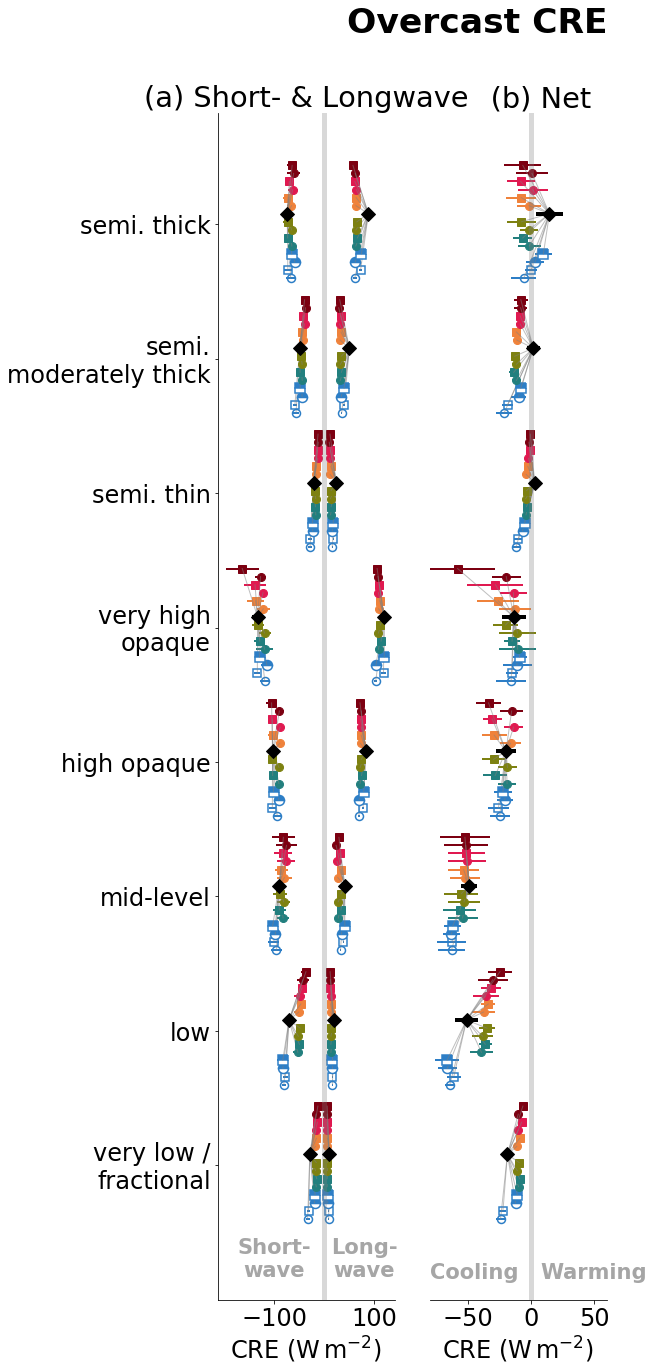

In [15]:
grey_fontsize = 21
fac = 0.6


fig, ax = pl.subplots( ncols = 2, figsize = (30*fac, 35*fac), )

pl.sca(ax[0])
vert_stacked_exp_plot( mvar, 'scre_ave' , var_err = dvar_q, doffset =0.06)
vert_stacked_exp_plot( mvar, 'lcre_ave' , var_err = dvar_q, doffset =0.06)

xlim = pl.xlim()
pl.text( -100, -0.7, 'Short-\nwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)

pl.text( 80, -0.7, 'Long-\nwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)
pl.xticks([-100,100])

sns.despine(ax = ax[0])
pl.title('(a) Short- & Longwave')


pl.sca(ax[1])
vert_stacked_exp_plot( mvar, 'net_cre_ave' , var_err = dvar_q, doffset =0.06)
sns.despine(left = True, ax = ax[1])
pl.title('     (b) Net')
pl.yticks([])
xlim = pl.xlim(-80, 60)

pl.text( -45, -0.8, 'Cooling', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)

pl.text( 50, -0.8, 'Warming', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)

#plegend()

for a in ax:
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE ($\mathrm{W\, m^{-2}}$)')
    a.set_ylim(-1,None)

#nawdex_analysis.plot.legend.plegend( fontsize = 22,  bbox_to_anchor = (3.2, 0.5) )
pl.suptitle('Overcast CRE', fontsize = 'x-large', fontweight = 'bold')

pl.subplots_adjust( left = 0.3, right = 0.6, top = 0.91 )
pl.savefig( '../pics/cre_overcast-vs-ct.png', dpi = 300,)


### Make a Plot for the Legend

This extra plot is made to get a legend that can be included in merged plots later.

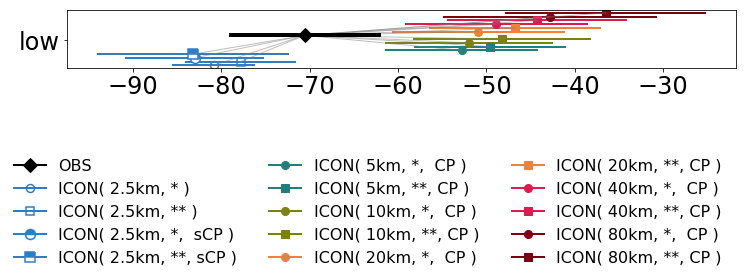

In [16]:
fig, ax = pl.subplots( ncols = 1, nrows = 1, figsize = (12, 8), )
pl.subplots_adjust(top = 0.9, bottom = 0.8)
vert_stacked_exp_plot( mvar, 'scre_ave' , var_err = dvar, doffset =0.06, catlist=['low'])
nawdex_analysis.plot.legend.plegend( fontsize = 16,  bbox_to_anchor = (1, -2.5), ncol = 3 )
pl.savefig('../pics/legend.png', dpi = 400)